In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import shutil
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Load the ResNet50 model pre-trained on ImageNet data
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

## Data Label Preparation

In [ ]:
import zipfile
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/Capstone/Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%time
import zipfile
import concurrent.futures
zf = zipfile.ZipFile('/content/drive/Shared drives/Capstone/Final Data/Images.zip')
def unzip(file):
    zf.extract(file)
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(unzip, zf.infolist())

CPU times: user 1min 21s, sys: 49.3 s, total: 2min 10s
Wall time: 1min 1s


In [ ]:
train_labels_path = '/content/drive/My Drive/Capstone/Data/10Classes/train.xlsx'
test_labels_path = '/content/drive/My Drive/Capstone/Data/10Classes/test.xlsx'
val_labels_path = '/content/drive/My Drive/Capstone/Data/10Classes/validation.xlsx'

In [ ]:
# Load the label data from the Excel files
train_df = pd.read_excel(train_labels_path)
test_df = pd.read_excel(test_labels_path)
val_df = pd.read_excel(val_labels_path)

In [ ]:
# train_df

In [ ]:
# test_df

In [ ]:
# val_df

In [ ]:
classes = val_df['class'].unique().tolist()
len(classes)

10

In [ ]:
print(classes)

['Consolidation', 'Effusion', 'Infiltration', 'Nodule', 'Cardiomegaly', 'Pleural Thickening', 'No Finding', 'Mass', 'Atelectasis', 'Pneumothorax']


In [ ]:
num_classes = len(classes)
num_classes

10

In [ ]:
train_dir = '/content/Images/Train'
test_dir = '/content/Images/Test'
val_dir = '/content/Images/Validation'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 64000 images belonging to 10 classes.
Found 16000 images belonging to 10 classes.
Found 20000 images belonging to 10 classes.


## ResNet50



In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False)

# Unfreeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = True


# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)  # assuming you have 10 classes

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

# Include it in the list of callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    reduce_lr  # adding the reduce learning rate callback

]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,  # Adjust based on the convergence of training and validation accuracy/loss
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=callbacks
)

# Save the model
model.save('/content/drive/My Drive/Capstone/Data/10Classes/keras_resnet50_model.h5')



Epoch 1/100
2000/2000 [==============================] - ETA: 0s - loss: 2.0407 - accuracy: 0.2668
Epoch 1: val_accuracy improved from -inf to 0.38319, saving model to best_model.keras
2000/2000 [==============================] - 318s 142ms/step - loss: 2.0407 - accuracy: 0.2668 - val_loss: 1.7314 - val_accuracy: 0.3832 - lr: 1.0000e-05
Epoch 2/100
2000/2000 [==============================] - ETA: 0s - loss: 1.6382 - accuracy: 0.4201
Epoch 2: val_accuracy improved from 0.38319 to 0.44781, saving model to best_model.keras
2000/2000 [==============================] - 279s 139ms/step - loss: 1.6382 - accuracy: 0.4201 - val_loss: 1.5503 - val_accuracy: 0.4478 - lr: 1.0000e-05
Epoch 3/100
2000/2000 [==============================] - ETA: 0s - loss: 1.3394 - accuracy: 0.5309
Epoch 3: val_accuracy improved from 0.44781 to 0.50756, saving model to best_model.keras
2000/2000 [==============================] - 277s 139ms/step - loss: 1.3394 - accuracy: 0.5309 - val_loss: 1.4069 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the saved model
model = load_model('/content/drive/My Drive/Capstone/Data/10Classes/keras_resnet50_model.h5')

# Evaluate the model on the test data
eval_result = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

# Predict on the test data
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Get most likely class indices
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)


625/625 [==============================] - 61s 95ms/step - loss: 2.0483 - accuracy: 0.6043
Test Loss: 2.0482583045959473, Test Accuracy: 0.6043000221252441
625/625 [==============================] - 57s 90ms/step
                         precision    recall  f1-score   support

       Atelectasis_test       0.54      0.48      0.51      2000
      Cardiomegaly_test       0.83      0.88      0.85      2000
     Consolidation_test       0.70      0.69      0.69      2000
          Effusion_test       0.60      0.60      0.60      2000
      Infiltration_test       0.41      0.38      0.40      2000
              Mass_test       0.63      0.61      0.62      2000
        No Finding_test       0.40      0.44      0.42      2000
            Nodule_test       0.56      0.54      0.55      2000
Pleural Thickening_test       0.67      0.71      0.69      2000
      Pneumothorax_test       0.69      0.70      0.69      2000

               accuracy                           0.60     20000
     

In [ ]:
val_loss = [
    1.7864, 1.7374, 1.6783, 1.5849, 1.5632, 1.5181, 1.5136, 1.4112, 1.3950, 1.3619,
    1.3122, 1.2982, 1.2573, 1.2515, 1.1741, 1.1779, 1.3772, 1.1524, 1.1032, 1.1329,
    1.1454, 1.1068, 1.0758, 1.0942, 1.0623, 1.1382, 1.0733, 1.0616, 1.2049, 1.0705,
    1.0104, 0.9954, 1.0068, 0.9916, 1.1173, 0.9997, 1.1408, 1.0465, 1.0239, 1.2275,
    0.8750, 0.8805, 0.8889, 0.8858, 0.9005, 0.8856, 0.8717, 0.8930, 0.8965, 0.9130,
    0.9127, 0.8972
]

train_acc = [0.3140, 0.3852, 0.4185, 0.4433, 0.4682, 0.4906, 0.5120, 0.5355, 0.5583, 0.5742,
             0.5901, 0.6083, 0.6171, 0.6309, 0.6444, 0.6559, 0.6650, 0.6741, 0.6774, 0.6882,
             0.6933, 0.7052, 0.7113, 0.7178, 0.7223, 0.7288, 0.7340, 0.7420, 0.7424, 0.7482,
             0.7535, 0.7585, 0.7658, 0.7685, 0.7687, 0.7748, 0.7777, 0.7818, 0.7831, 0.7892,
             0.8291, 0.8412, 0.8499, 0.8529, 0.8574, 0.8596, 0.8661, 0.8646, 0.8681, 0.8703,
             0.8730, 0.8743]
val_acc = [0.3655, 0.3818, 0.4040, 0.4372, 0.4415, 0.4617, 0.4736, 0.5022, 0.5123, 0.5272,
           0.5404, 0.5484, 0.5605, 0.5627, 0.5881, 0.5897, 0.5586, 0.6029, 0.6157, 0.6112,
           0.6067, 0.6254, 0.6318, 0.6282, 0.6372, 0.6200, 0.6371, 0.6479, 0.6229, 0.6482,
           0.6587, 0.6666, 0.6633, 0.6696, 0.6506, 0.6731, 0.6526, 0.6579, 0.6714, 0.6544,
           0.7193, 0.7238, 0.7253, 0.7332, 0.7259, 0.7329, 0.7402, 0.7351, 0.7377, 0.7374,
           0.7333, 0.7399]

train_loss = [1.9136, 1.7329, 1.6448, 1.5746, 1.5059, 1.4407, 1.3769, 1.3174, 1.2480, 1.1993,
              1.1545, 1.1034, 1.0732, 1.0374, 0.9946, 0.9637, 0.9372, 0.9085, 0.8951, 0.8672,
              0.8476, 0.8176, 0.8023, 0.7834, 0.7694, 0.7484, 0.7372, 0.7191, 0.7105, 0.6969,
              0.6785, 0.6683, 0.6519, 0.6438, 0.6402, 0.6221, 0.6141, 0.6032, 0.5969, 0.5844,
              0.4783, 0.4408, 0.4169, 0.4125, 0.3964, 0.3908, 0.3745, 0.3772, 0.3689, 0.3634,
              0.3570, 0.3527]

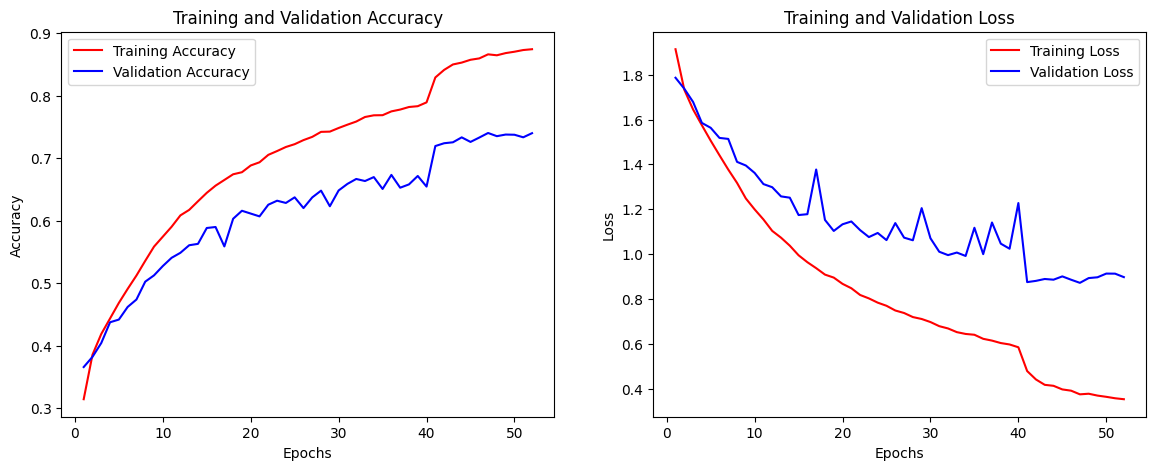

In [ ]:
import matplotlib.pyplot as plt
# Plotting
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(14, 5))

# Plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

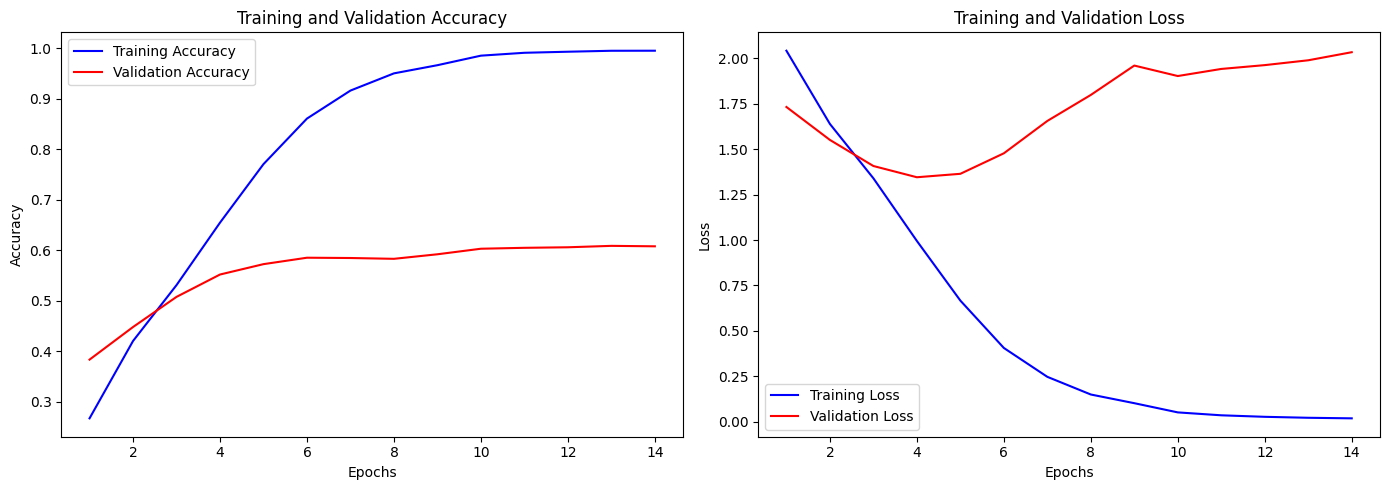

In [1]:
import matplotlib.pyplot as plt

# Data extracted from the user's text
epochs = range(1, 15)
training_accuracy = [0.2668, 0.4201, 0.5309, 0.6547, 0.7707, 0.8610, 0.9165, 0.9506, 0.9668, 0.9857, 0.9914, 0.9935, 0.9954, 0.9955]
validation_accuracy = [0.38319, 0.44781, 0.50756, 0.55187, 0.57244, 0.58519, 0.5846, 0.5830, 0.59200, 0.60300, 0.60481, 0.60588, 0.60869, 0.6078]
training_loss = [2.0407, 1.6382, 1.3394, 0.9949, 0.6670, 0.4066, 0.2479, 0.1507, 0.1030, 0.0524, 0.0364, 0.0281, 0.0228, 0.0197]
validation_loss = [1.7314, 1.5503, 1.4069, 1.3451, 1.3640, 1.4767, 1.6546, 1.7976, 1.9591, 1.9015, 1.9405, 1.9615, 1.9881, 2.0325]

# Plotting Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
